# Mount Google Drive

In [ ]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
 
# Generate auth tokens for Colab
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
!pip install -U -q PyDrive
 
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
 
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
 
# Create a directory and mount Google Drive using that directory.
!mkdir -p drive
!google-drive-ocamlfuse drive
 
print ('Files in Drive:')
!ls drive/
 
# Create a file in Drive.
!echo "This newly created file will appear in your Drive file list." > drive/created.txt

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 160772 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.26-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.26-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.26-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

# Including Required Libraries

In [ ]:
%tensorflow_version 1.x
!pip install 'h5py<3.0.0'
from google.colab.patches import cv2_imshow
import numpy as np
import sys
import os
import tensorflow as tf
from keras import optimizers
from keras.layers import Input, Add, concatenate
from keras.layers.merge import Concatenate
from keras.models import Model
from keras.layers import Dense, Flatten, Reshape, Dropout
from keras.layers import Convolution1D, MaxPooling1D, BatchNormalization
from keras.layers import Lambda
from keras.utils import np_utils
from keras.models import load_model
import h5py
from matplotlib.pyplot import imshow
import cv2
import glob
import math
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.imagenet_utils import decode_predictions
from keras import backend as K
import matplotlib.pyplot as plt
%matplotlib inline

BASE_DIR = os.path.dirname(os.path.abspath('__file__'))
sys.path.append(BASE_DIR)

TensorFlow 1.x selected.


Using TensorFlow backend.


# Data Preprocessing

Paths for data

In [ ]:
pcd_path = "drive/velodyne/"
label_path = "drive/labels/"
calib_path = "drive/calib/"
img_path = "drive/images/"

## Obtain 2-D Labels

In [ ]:
def read_label_from_txt(label_path):

    bounding_box = None
    flag = 0
    with open(label_path, "r") as f:
        labels = f.read().split("\n")
        for label in labels:
            if not label:
                continue
            label = label.split(" ")
            if (label[0] == "DontCare"):
                continue
            if label[0] == ("Car") or label[0]=="Van" or label[0]=="Pedestrian" or  label[0]== "Truck" or  label[0]=="Tram" or label[0]=="Cyclist" or label[0]=="Misc":                 
                if flag == 0:
                  bounding_box = np.expand_dims(np.array(label[4:8]),axis=0)
                  flag=1
                else:
                  bounding_box = np.append(bounding_box,np.expand_dims(np.array(label[4:8]),axis=0),axis=0)
    return bounding_box

def Create2dLabelsArray (label_path=None, label_type="txt"):
  
    filenames_labels = [d for d in sorted(os.listdir(label_path)) if d[0]!='.']
    labels2d = None
    for d in filenames_labels:
        value = d[0:6]
        print(value)
        lab_path = label_path + value + '.txt'
        label2d = read_label_from_txt(lab_path)
        if labels2d is None:
            labels2d = label2d            
        else:
            labels2d = np.concatenate((labels2d, label2d), axis = 0)
            print(labels2d.shape)
    return labels2d

labels2d =  Create2dLabelsArray(label_path)
np.save('drive/multi/labels-2d.npy',  labels2d)

## 2. Camera Chain

Obtain 2-D image crops by increasing the dimensions of the 2-D Labels provided in the KITTI dataset

In [ ]:
def read_label_from_txt(label_path):
    """Read label from txt file."""
    text = np.fromfile(label_path)
    bounding_box = []
    with open(label_path, "r") as f:
        labels = f.read().split("\n")
        for label in labels:
            if not label:
                continue
            label = label.split(" ")
            if (label[0] == "DontCare"):
                continue
            y_class = [int(label[0]=="Car"), int(label[0]=="Van"), int(label[0]=="Pedestrian"), int(label[0]== "Truck"), int(label[0]=="Tram"), int(label[0]=="Cyclist"), int(label[0]=="Misc" )]
            if label[0] == ("Car") or label[0]=="Van" or label[0]=="Pedestrian" or  label[0]== "Truck" or  label[0]=="Tram" or label[0]=="Cyclist" or label[0]=="Misc":
                y_labels = list(np.hstack((label[4:8], y_class)))
                bounding_box.append(y_labels)
                #break
    return bounding_box  
 
def read_labels(label_path, label_type, img_path, calib_path=None, is_velo_cam=False, proj_velo=None):
    """Read labels from txt file.
    Original Label value is shifted about 0.27m from object center.
    So need to revise the position of objects.
    """
    filenames_imgs = [img_path+d for d in sorted(os.listdir(img_path)) if d[0]!='.']
    filenames_labels = [label_path+d for d in sorted(os.listdir(label_path)) if d[0]!='.']
 
    roi_images = None
    idx=0
    for d in filenames_imgs:
      if label_type == "txt": #TODO
        print(d)
        bb = read_label_from_txt(filenames_labels[idx])
        for i in range(len(bb)):
          xmin = int(float(bb[i][0]))
          ymin = int(float(bb[i][1]))
          xmax = int(float(bb[i][2]))
          ymax = int(float(bb[i][3]))
          img = cv2.imread(d)
 
#Shifting the minimum value of x and y coordinates by 10% less and shifting the maximum value of x and y coordinates by 10% more as specified by PointFusion paper
          if ymin-0.1*(ymax-ymin)>=0 and xmin-0.1*(xmax-xmin)>=0:
            roi_imgOne = img[int(ymin-0.1*(ymax-ymin)):int(ymax+0.1*(ymax-ymin)),int(xmin-0.1*(xmax-xmin)):int(xmax+0.1*(xmax-xmin))]
          
          if ymin-0.1*(ymax-ymin)>=0 and xmin-0.1*(xmax-xmin)<0:
            roi_imgOne = img[int(ymin-0.1*(ymax-ymin)):int(ymax+0.1*(ymax-ymin)),0:abs(int(xmax+0.1*(xmax-xmin)))] 
          
          if ymin-0.1*(ymax-ymin)<0 and xmin-0.1*(xmax-xmin)>=0:
            roi_imgOne = img[0:abs(int(ymax+0.1*(ymax-ymin))),int(xmin-0.1*(xmax-xmin)):int(xmax+0.1*(xmax-xmin))]
          
          if ymin-0.1*(ymax-ymin)<0 and xmin-0.1*(xmax-xmin)<0:
            roi_imgOne = img[0:abs(int(ymax+0.1*(ymax-ymin))),0:abs(int(xmax+0.1*(xmax-xmin)))]
          print((ymin-0.1*(ymax-ymin),xmin-0.1*(xmax-xmin)))
          print(roi_imgOne.shape)
          roi_imgTwo = cv2.resize(roi_imgOne,(224,224))
          roi_img = np.expand_dims(roi_imgTwo, axis=0)
          if roi_images is None:
            roi_images = roi_img
          else:
            roi_images = np.concatenate((roi_images,roi_img), axis = 0)
      idx=idx+1;
    return roi_images
images_cropped = read_labels(label_path,'txt',img_path)
np.save('drive/images_cropped.npy',images_cropped)


Load the cropped images and Visualize

In [ ]:
images_cropped = np.load('drive/cropped_images.npy')
cv2_imshow(images_cropped[8])

Divide the images in to batches

In [ ]:
np.save('drive/Batch Images/batch_imagesOne.npy',images_cropped[:7000])
np.save('drive/Batch Images/batch_imagesTwo.npy',images_cropped[7000:14000])
np.save('drive/Batch Images/batch_imagesThree.npy',images_cropped[14000:21000])
np.save('drive/Batch Images/batch_imagesFour.npy',images_cropped[21000:28000])
np.save('drive/Batch Images/batch_imagesFive.npy',images_cropped[28000:35000])
np.save('drive/Batch Images/batch_imagesSix.npy',images_cropped[35000:])

Preprocess the batch images for ResNet 

In [ ]:
batch_images= np.load('drive/Batch Images/batch_imagesFive.npy')
from keras.applications import resnet50
resnet_model = resnet50.ResNet50(weights='imagenet')
np.save('drive/processed_imagesFive.npy',resnet50.preprocess_input(batch_images))

Pass the Training cropped images through ResNet

In [ ]:
processed_images = np.load('drive/processed_imagesFive.npy')
from keras.applications import resnet50
resnet_model = resnet50.ResNet50(weights='imagenet')

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

#tf.compat.v1.get_default_graph()
#extract final layer called avg_pool with size 1 by 2048
layer_name = 'avg_pool'
layer = resnet_model.get_layer(layer_name)
#layer = resnet_model.layers[layer_num]

intermediate_layer_model = Model(inputs=resnet_model.input,
                                 outputs=layer.output)
intermediate_layer_model.summary()
intermediate_output = intermediate_layer_model.predict(processed_images)
print("Shape of Processed Images: ", processed_images.shape)
print("Layer used: ", layer.name)
print("Shape of layer output:", intermediate_output.shape)

np.save('drive/IntermediateOutputsMultiobject/intermediate_outputFive.npy', intermediate_output)

Load and Concatenate the Outputs obtained for batch images that were passed throug ResNet

In [ ]:
intermediate_output1 = np.load('drive/IntermediateOutputsMultiobject/intermediate_outputOne.npy')
intermediate_output2 = np.load('drive/IntermediateOutputsMultiobject/intermediate_outputTwo.npy')
intermediate_output3 = np.load('drive/IntermediateOutputsMultiobject/intermediate_outputThree.npy')
intermediate_output4 = np.load('drive/IntermediateOutputsMultiobject/intermediate_outputFour.npy')
intermediate_output5 = np.load('drive/IntermediateOutputsMultiobject/intermediate_outputFive.npy')
intermediate_output6 = np.load('drive/IntermediateOutputsMultiobject/intermediate_outputSix.npy')
intermediate_output = np.append(intermediate_output1,intermediate_output2,axis = 0)
intermediate_output = np.append(intermediate_output,intermediate_output3, axis = 0)
intermediate_output = np.append(intermediate_output,intermediate_output4, axis = 0)
intermediate_output = np.append(intermediate_output,intermediate_output5, axis = 0)
intermediate_output = np.append(intermediate_output,intermediate_output6, axis = 0)
np.save('drive/IntermediateOutputsMultiobject/intermediate_output_multi.npy',intermediate_output)

## 1.    Lidar Chain


Functions for preprocessing of pointclouds and labels

In [ ]:
def filter_camera_angle(places):
    """Filter camera angles for KiTTI Datasets"""
    bool_in = np.logical_and((places[:, 1] < places[:, 0] - 0.27), (-places[:, 1] < places[:, 0] - 0.27))
    # bool_in = np.logical_and((places[:, 1] < places[:, 0]), (-places[:, 1] < places[:, 0]))
    return places[bool_in]
    
def center_to_sphere(places, size, resolution=0.50, min_value=np.array([0., -50., -4.5]), scale=4, x=(0, 90), y=(-50, 50), z=(-4.5, 5.5)):
    """Convert object label to Training label for objectness loss"""
    x_logical = np.logical_and((places[:, 0] < x[1]), (places[:, 0] >= x[0]))
    y_logical = np.logical_and((places[:, 1] < y[1]), (places[:, 1] >= y[0]))
    z_logical = np.logical_and((places[:, 2] < z[1]), (places[:, 2] >= z[0]))
    xyz_logical = np.logical_and(x_logical, np.logical_and(y_logical, z_logical))
    center = places.copy()
    center[:, 2] = center[:, 2] + size[:, 0] / 2.
    sphere_center = ((center[xyz_logical] - min_value) / (resolution * scale)).astype(np.int32)
    return sphere_center
 
def sphere_to_center(p_sphere, resolution=0.5, scale=4, min_value=np.array([0., -50., -4.5])):
    """from sphere center to label center"""
    center = p_sphere * (resolution*scale) + min_value
    return center

Loading pointcloud from bin file

In [ ]:
def load_pc_from_bin(bin_path,label_path):
    """Load a bin file to a np array"""
    num_select = 2048
    selected_points =[]
    obj = np.fromfile(bin_path, dtype = np.float32).reshape(-1,4)
    pc = filter_camera_angle(obj)
    index = np.random.choice(pc.shape[0], num_select, replace=False)
    for i in range(len(index)):
        selected_points.append(pc[index[i]][0:3])
    selected_points = np.array(selected_points).reshape(1,-1,3)# return N*3 array
    return selected_points

Reading the calibration file

In [ ]:
def read_calib_file(calib_path):
    """Read a calibration file."""
    data = {}
    with open(calib_path, 'r') as f:
        for line in f.readlines():
            if not line or line == "\n":
                continue
            key, value = line.split(':', 1)
            try:
                data[key] = np.array([float(x) for x in value.split()])
            except ValueError:
                pass
    return data

Pointcloud to image projection

In [ ]:
def proj_to_velo(calib_data):
    """Projection matrix to 3D axis for 3D Label"""
    rect = calib_data["R0_rect"].reshape(3, 3)
    velo_to_cam = calib_data["Tr_velo_to_cam"].reshape(3, 4)
    inv_rect = np.linalg.inv(rect)
    inv_velo_to_cam = np.linalg.pinv(velo_to_cam[:, :3])
    return np.dot(inv_velo_to_cam, inv_rect)

Reading Labels

In [ ]:
def read_label_from_txt(label_path):
    """Read label from txt file."""
    text = np.fromfile(label_path)
    bounding_box = []
    with open(label_path, "r") as f:
        labels = f.read().split("\n")
        for label in labels:
            if not label:
                continue
            label = label.split(" ")
            if (label[0] == "DontCare"):
                continue
            count[k]=count[k]+1
            y_class = [int(label[0]=="Car"), int(label[0]=="Van"), int(label[0]=="Pedestrian"), int(label[0]== "Truck"), int(label[0]=="Tram"), int(label[0]=="Cyclist"), int(label[0]=="Misc" )]
            if label[0] == ("Car") or label[0]=="Van" or label[0]=="Pedestrian" or  label[0]== "Truck" or  label[0]=="Tram" or label[0]=="Cyclist" or label[0]=="Misc":
                y_labels = list(np.hstack((label[8:15], y_class)))
                bounding_box.append(y_labels)
                #break
    if bounding_box:
        data = np.array(bounding_box, dtype=np.float32)
        return data[:, 3:6], data[:, :3], data[:, 6], data[:,7:] 
    else:
        return None, None, None, None
 
def read_labels(label_path, label_type, calib_path=None, is_velo_cam=False, proj_velo=None):
    """Read labels from txt file.
    Original Label value is shifted about 0.27m from object center.
    So need to revise the position of objects.
    """
    if label_type == "txt": #TODO
        places, size, rotates, y_class = read_label_from_txt(label_path)
        if places is None:
            return None, None, None, None
        rotates = np.pi / 2 - rotates
        dummy = np.zeros_like(places)
        dummy = places.copy()
        if calib_path:
            places = np.dot(dummy, proj_velo.transpose())[:, :3]
        else:
            places = dummy
        if is_velo_cam:
            places[:, 0] += 0.27
 
    data_combined = []
    for p, r, s , cl in zip(places, rotates, size, y_class):
        ps = np.hstack((cl[:],p[:],s[:]))
        data_combined.append(list(np.append(ps, r)))
        
    return places, rotates, size, y_class

> Store the pointcloud file index for each label and obtain 3-D labels and Classes

In [ ]:
def get_boxcorners(places, rotates, size):
    """Create 8 corners of bounding box from bottom center."""
    corners = []
    for place, rotate, sz in zip(places, rotates, size):
        x, y, z = place
        h, w, l = sz
        corner = np.array([
            [x - l / 2., y - w / 2., z],
            [x + l / 2., y - w / 2., z],
            [x - l / 2., y + w / 2., z],
            [x - l / 2., y - w / 2., z+h],
            [x - l / 2., y + w / 2., z+h],
            [x + l / 2., y + w / 2., z],
            [x + l / 2., y - w / 2., z+h],
            [x + l / 2., y + w / 2., z+h],
        ])
        
        corner -= np.array([x, y, z])
 
        rotate_matrix = np.array([
            [np.cos(rotate), -np.sin(rotate), 0],
            [np.sin(rotate), np.cos(rotate), 0],
            [0, 0, 1]
        ])
 
        a = np.dot(corner, rotate_matrix.transpose())
        a += np.array([x, y, z])
        corners.append(a)
    return np.array(corners)
def process( label_path=None, calib_path=None, dataformat="bin", label_type="txt", is_velo_cam=False):
    labels_in_each_image = np.zeros(7481)
    k=0
    p = []
    pc = None
    bounding_boxes = None
    places = None
    rotates = None
    size = None
    proj_velo = None
    
    filenames_labels = [d for d in sorted(os.listdir(label_path)) if d[0]!='.']
    classes_multi = None
    labels_multi = None
    for d in filenames_labels:
        value = d[0:6]
        print(value)
        cal_path = calib_path + value + '.txt'
        lab_path = label_path + value + '.txt'
        cur_calib = read_calib_file(cal_path)
        proj_velo = proj_to_velo(cur_calib)[:, :3]
        places, rotates, size, classes,num_labels= read_labels(lab_path, label_type, cal_path , is_velo_cam=is_velo_cam, proj_velo=proj_velo)
        labels_in_each_image[k] = num_labels
        labels = get_boxcorners(places, rotates, size)
        if places is None:
            continue
        if train_labels is None:
            labels_multi = labels
            classes_multi = classes
        else:
            labels_multi = np.concatenate((train_labels, corners), axis = 0)
            classes_multi = np.concatenate((train_classes, classes), axis = 0)
        k=k+1          
    return  labels_multi,classes_multi, labels_in_each_image
 
labels_multi,classes_multi, labels_in_each_image = process(label_path, calib_path, dataformat="bin", is_velo_cam=True)
np.save('drive/labels_multiple.npy', train_labels)
np.save('drive/labels_in_each_image.npy',labels_in_each_image)
np.save('drive/classes_multiple.npy',classes_multi)

Obtain PointCloud crops for each label

In [ ]:
labels2d = np.load('drive/multi/labels-2d.npy')
velodyne_path = 'drive/velodyne pointclouds/'
def velocorners_to_imagecorners(point,calib_data):
    point.append(1)
    point = np.array(point).reshape((4,1))
    
    R0_rect = calib_data["R0_rect"].reshape(3, 3)
    Tr_velo_to_cam = calib_data["Tr_velo_to_cam"].reshape(3, 4)
    P2 = calib_data["P2"].reshape(3, 4)
    
    R = np.zeros((4,4))
    R[:3,:3] = R0_rect
    R[3,3] = 1
    
    T = np.zeros((4,4))
    T[:3,:4] = Tr_velo_to_cam
    T[3,3] = 1
    
    point_image = np.dot(P2,np.dot(R,np.dot(T,point)))
    return list(np.squeeze(point_image.reshape(1,3)))

def CroppingPointCloud(velodyne_path,labels2d,label_path, dataformat="bin", label_type="txt", is_velo_cam=False):   
    pc = None
    filenames_velo = [d for d in sorted(os.listdir(velodyne_path)) if d[0]!='.']
    filenames_labels = [d for d in sorted(os.listdir(label_path)) if d[0]!='.']
    filenames_calib = [d for d in sorted(os.listdir(calib_path)) if d[0]!='.']
    pointclouds_multi = np.zeros((labels2d.shape[0],400,3))

    idx =0
    file_idx= 0  
    for d in filenames_velo:
        value = d[0:6]
        print(value)
        velo_path = velodyne_path + value + '.bin'
        lab_path = label_path + filenames_labels[file_idx]
        cal_path = calib_path + filenames_calib[file_idx]
        calib_data = read_calib_file(cal_path)
        pc = np.squeeze(load_pc_from_bin(velo_path,lab_path))
        with open(lab_path, "r") as f:
          labels = f.read().split("\n")
          for label in labels:
            if not label:
              continue
            label = label.split(" ")
            if (label[0] == "DontCare"):
              continue
            if label[0] == ("Car") or label[0]=="Van" or label[0]=="Pedestrian" or  label[0]== "Truck" or  label[0]=="Tram" or label[0]=="Cyclist" or label[0]=="Misc":  
              xmin = labels2d[idx,0]
              ymin = labels2d[idx,1]
              xmax = labels2d[idx,2]
              ymax = labels2d[idx,3]
              count = 0
              for i in range(pc.shape[0]):
                pc_point = list(pc[i])
                pc_on_img = velocorners_to_imagecorners(pc_point,calib_data)
                pc_on_img = pc_on_img/pc_on_img[2]
                #pc_on_img[pc_on_img<0] = 0
                if count < 400:       
                  if (pc_on_img[0] >= 0.9*float(xmin)) and (pc_on_img[1] >= 0.9*float(ymin)) and (pc_on_img[0] <= 1.1*float(xmax)) and  (pc_on_img[1] <= 1.1*float(ymax)):
                    print(idx)
                    pointclouds_multi[idx,count,:] = pc[i,:]
                    count +=1
            idx= idx+1
        file_idx = file_idx+1
    return pointclouds_multi 
pointclouds_multi = CroppingPointCloud(velodyne_path,labels2d,label_path)
np.save('drive/multi/pointclouds-multiple.npy',pointclouds_multi)

#Training

## Data Splitting for obtain Training, Validation and Testing data

In [ ]:
point_clouds = np.load('drive/multi/pointclouds_multiple.npy')
labels_in_each_image = np.load('drive/multi/labels_in_each_image.npy')
labels_multiple = np.load('drive/multi/labels_multiple.npy')
classes_multiple = np.load('drive/multi/classes_multiple.npy')
intermediate_output = np.load('drive/multi/intermediate_output_multi.npy')

count = 0
idx = 0
labelsList=[]

for i in labels_in_each_image:
  labelsList+=[[]]
  for j in range(int(i)):  
    labelsList[count].append(idx)
    idx += 1
  count+=1
#Generating Random Indices
#Obtaining Training Data
index = np.load('drive/Colab Notebooks/index.npy')
train_index= index[:6000]


train_clouds = None
train_labels = None
train_classes = None
train_intermediate = None

flag = 0
print(intermediate_output.shape)
for i in train_index:
  for j in range(int(labels_in_each_image[i])):
    train_cloud = point_clouds[labelsList[int(i)][j]]
    train_label = labels_multiple[labelsList[int(i)][j]]
    train_class = classes_multiple[labelsList[int(i)][j]]
    train_inter = intermediate_output[labelsList[int(i)][j]]
    
    train_cloud = train_cloud.reshape(1,400,3)
    train_label = train_label.reshape(1,8,3)
    train_class = train_class.reshape(1,7)
    train_inter = train_inter.reshape(1,2048)
 
    
    if flag == 0:
      train_clouds = train_cloud
      train_labels = train_label
      train_classes = train_class
      train_intermediate = train_inter
      flag = 1
    else:
      train_clouds = np.append(train_clouds,train_cloud,axis=0)
      train_labels = np.append(train_labels,train_label,axis=0)
      train_classes = np.append(train_classes,train_class,axis=0)
      train_intermediate = np.append(train_intermediate,train_inter,axis=0)


#Obtaining Validation Data
val_index= index[6000:6748]
val_clouds = None
val_labels = None
val_classes = None
val_intermediate = None
flag = 0

for i in val_index:
  for j in range(int(labels_in_each_image[i])):
    val_cloud = point_clouds[labelsList[int(i)][j]]
    val_label = labels_multiple[labelsList[int(i)][j]]
    val_class = classes_multiple[labelsList[int(i)][j]]
    val_inter = intermediate_output[labelsList[int(i)][j]]
    
    val_cloud = val_cloud.reshape(1,400,3)
    val_label = val_label.reshape(1,8,3)
    val_class = val_class.reshape(1,7)
    val_inter = val_inter.reshape(1,2048)
    if flag == 0:
      val_clouds = val_cloud
      val_labels = val_label
      val_classes = val_class      
      val_intermediate = val_inter
      flag = 1
    else:
      val_clouds = np.append(val_clouds,val_cloud,axis=0)
      val_labels = np.append(val_labels,val_label,axis=0)
      val_classes = np.append(val_classes,val_class,axis=0)
      val_intermediate = np.append(val_intermediate,val_inter,axis=0)

test_index=index[6748:]
test_clouds = None
test_labels = None
test_classes = None
test_intermediate = None

flag = 0

for i in test_index:
  for j in range(int(labels_in_each_image[i])):
    test_cloud = point_clouds[labelsList[int(i)][j]]
    test_label = labels_multiple[labelsList[int(i)][j]]
    test_class = classes_multiple[labelsList[int(i)][j]]
    test_inter = intermediate_output[labelsList[int(i)][j]]
    
    test_cloud = test_cloud.reshape(1,400,3)
    test_label = test_label.reshape(1,8,3)
    test_class = test_class.reshape(1,7)
    test_inter  = test_inter.reshape(1,2048)
    
    if flag == 0:
      test_clouds = test_cloud
      test_labels = test_label
      test_classes = test_class
      test_intermediate = test_inter
      flag = 1
    else:
      test_clouds = np.append(test_clouds,test_cloud,axis=0)
      test_labels = np.append(test_labels,test_label,axis=0)
      test_classes = np.append(test_classes,test_class,axis=0)
      test_intermediate = np.append(test_intermediate,test_inter,axis=0)

np.save('drive/multi/test_clouds.npy',test_clouds)
np.save('drive/multi/test_labels.npy',test_labels)
np.save('drive/multi/test_classes.npy',test_classes)
np.save('drive/multi/test_intermediate.npy',test_intermediate)
np.save('drive/multi/train_clouds.npy',train_clouds)
np.save('drive/multi/train_labels.npy',train_labels)
np.save('drive/multi/train_classes.npy',train_classes)
np.save('drive/multi/train_intermediate.npy',train_intermediate)
np.save('drive/multi/val_clouds.npy',val_clouds)
np.save('drive/multi/val_labels.npy',val_labels)
np.save('drive/multi/val_classes.npy',val_classes)
np.save('drive/multi/val_intermediate.npy',val_intermediate)

(40348, 2048)


In [ ]:
train_clouds = np.load('drive/multi/train_clouds.npy')
train_labels = np.load('drive/multi/train_labels.npy')
train_classes = np.load('drive/multi/train_classes.npy')
train_intermediate = np.load('drive/multi/train_intermediate.npy')
val_clouds = np.load('drive/multi/val_clouds.npy')
val_labels = np.load('drive/multi/val_labels.npy')
val_classes= np.load('drive/multi/val_classes.npy')
val_intermediate = np.load('drive/multi/val_intermediate.npy')

## Model Definition

In [ ]:
def mat_mul(A, B):
    return tf.matmul(A, B)
 
# number of points in each sample
num_points = 400
 
# number of categories
k = 7
 
# define optimizer
adam = optimizers.Adam(lr=0.001, decay=0.7)
 
# ------------------------------------ Pointnet Architecture
# input_Transformation_net
input_points = Input(shape=(num_points, 3))  
x = Convolution1D(64, 1, activation='relu',
                  input_shape=(num_points, 3))(input_points)
#x = BatchNormalization()(x)
x = Convolution1D(128, 1, activation='relu')(x)
#x = BatchNormalization()(x)
x = Convolution1D(1024, 1, activation='relu')(x)
#x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=num_points)(x)
x = Dense(512, activation='relu')(x)
#x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
#x = BatchNormalization()(x)
x = Dense(9, weights=[np.zeros([256, 9]), np.array([1, 0, 0, 0, 1, 0, 0, 0, 1]).astype(np.float32)])(x)
input_T = Reshape((3, 3))(x)
 
# forward net --- MLP in PointNet
g = Lambda(mat_mul, arguments={'B': input_T})(input_points)
g = Convolution1D(64, 1, input_shape=(num_points, 3), activation='relu')(g)
#g = BatchNormalization()(g)
g = Convolution1D(64, 1, input_shape=(num_points, 3), activation='relu')(g)
#g = BatchNormalization()(g)
 
# feature transform net
f = Convolution1D(64, 1, activation='relu')(g)
#f = BatchNormalization()(f)
f = Convolution1D(128, 1, activation='relu')(f)
#f = BatchNormalization()(f)
f = Convolution1D(1024, 1, activation='relu')(f)
#f = BatchNormalization()(f)
f = MaxPooling1D(pool_size=num_points)(f)
f = Dense(512, activation='relu')(f)
#f = BatchNormalization()(f)
f = Dense(256, activation='relu')(f)
#f = BatchNormalization()(f)
f = Dense(64 * 64, weights=[np.zeros([256, 64 * 64]), np.eye(64).flatten().astype(np.float32)])(f)
feature_T = Reshape((64, 64))(f)
 
# forward net
g = Lambda(mat_mul, arguments={'B': feature_T})(g)
g = Convolution1D(64, 1, activation='relu')(g)
#g = BatchNormalization()(g)
g = Convolution1D(128, 1, activation='relu')(g)
#g = BatchNormalization()(g)
g = Convolution1D(1024, 1, activation='relu')(g)
#g = BatchNormalization()(g)
 
# global_feature
global_feature = MaxPooling1D(pool_size=num_points)(g)
global_feature = Flatten()(global_feature)
 
# point_net_cls
#c = Dense(512, activation='relu')(global_feature)
#c = BatchNormalization()(c)
#c = Dropout(rate=0.7)(c)
#c = Dense(256, activation='relu')(c)
#c = BatchNormalization()(c)
#c = Dropout(rate=0.7)(c)
#c = Dense(k, activation='softmax')(c)
#prediction = Flatten()(c)
# --------------------------------------------------end of pointnet
 
#Fusion
 
resnet_activation = Input(shape=(train_intermediate.shape[1],), name='intermediate_output')
f = Concatenate()([global_feature, resnet_activation])
 
#Definition of MLP Layer
f = Dense(512, activation='relu')(f)
f = Dense(128, activation='relu')(f)
f = Dense(128, activation='relu')(f)
boxes = Dense(24)(f)
classes =Dense(7,activation = 'sigmoid')(f)
 
 
# print the model summary
model = Model(inputs=[input_points, resnet_activation], outputs=[boxes, classes])
print(model.summary())

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 400, 3)       0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 400, 3)       0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 400, 64)      256         lambda_1[0][0]                   
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 400, 64)      4160        conv1d_4[0][0]                   
__________

## Model Training

In [ ]:
train_labels = train_labels.reshape(-1,24)
val_labels = val_labels.reshape(-1,24)
HUBER_DELTA = 0.5
def smoothL1(y_true, y_pred):
   x   = K.abs(y_true - y_pred)
   x   = K.switch(x < HUBER_DELTA, 0.5 * x ** 2, HUBER_DELTA * (x - 0.5 * HUBER_DELTA))
   return  K.sum(x)   
  
#epoch number
epo = 100
# define optimizer
adam = optimizers.Adam(lr=0.001, decay=0.7)
# compile classification model
model.compile(optimizer='adam',
              loss=[smoothL1,'mean_squared_error' ],
              metrics=['accuracy'])

history = model.fit(x = [train_clouds, train_intermediate], y= [train_labels, train_classes], batch_size=32, epochs=epo, validation_data=([val_clouds, val_intermediate], [val_labels, val_classes]), shuffle=True, verbose=1)
import pickle

with open('drive/Colab Notebooks/trainHistory-multiple-100-2.0', 'wb') as file_pi:
     pickle.dump(history.history, file_pi)
model.save_weights('drive/Colab Notebooks/weights-multiple-100-2.0.h5')

Train on 32316 samples, validate on 4098 samples
Epoch 1/100
32316/32316 [==============================] - 50s 2ms/step - loss: 157.6532 - dense_10_loss: 157.6215 - dense_11_loss: 0.0336 - dense_10_accuracy: 0.2927 - dense_11_accuracy: 0.8545 - val_loss: 223.6855 - val_dense_10_loss: 222.2526 - val_dense_11_loss: 0.0337 - val_dense_10_accuracy: 0.2042 - val_dense_11_accuracy: 0.8524
Epoch 2/100
32316/32316 [==============================] - 49s 2ms/step - loss: 151.2405 - dense_10_loss: 151.2004 - dense_11_loss: 0.0326 - dense_10_accuracy: 0.2907 - dense_11_accuracy: 0.8597 - val_loss: 197.1417 - val_dense_10_loss: 195.8208 - val_dense_11_loss: 0.0334 - val_dense_10_accuracy: 0.2396 - val_dense_11_accuracy: 0.8502
Epoch 3/100
32316/32316 [==============================] - 49s 2ms/step - loss: 145.2036 - dense_10_loss: 145.1705 - dense_11_loss: 0.0321 - dense_10_accuracy: 0.2991 - dense_11_accuracy: 0.8602 - val_loss: 191.6193 - val_dense_10_loss: 190.2423 - val_dense_11_loss: 0.0318 -

# Evaluation

In [ ]:
test_clouds = np.load('drive/multi/test_clouds.npy')
test_labels = np.load('drive/multi/test_labels.npy')
test_classes = np.load('drive/multi/test_classes.npy')
test_intermediate = np.load('drive/multi/test_intermediate.npy')

> ## Required Functions



In [ ]:
def velocorners_to_imagecorners(point,calib_data):
    '''converts velo points to image points
    Based on the readme file for 3D object detection, x = P2 * R0_rect * Tr_velo_to_cam * y
    R0_rect contains a 3x3 matrix which you need to extend to a 4x4 matrix by adding a 1 as the bottom-right element 
    and 0's elsewhere.
    Tr_xxx is a 3x4 matrix (R|t), which you need to extend to a 4x4 matrix in the same way
    Remember, that calib data has to extracted for the relevant file instance
    
    Input: 
    point: 1 point in the velodyne coordinate, a list
    calib_data: calib file for that example
    
    Output:
    point in the 2D image coordinate as a 3 member list
    
    Scheme of i'''
    #appending the point with 1 for homogenization and making a numpy array
    point.append(1)
    point = np.array(point).reshape((4,1))
    
    R0_rect = calib_data["R0_rect"].reshape(3, 3)
    Tr_velo_to_cam = calib_data["Tr_velo_to_cam"].reshape(3, 4)
    P2 = calib_data["P2"].reshape(3, 4)
    
    R = np.zeros((4,4))
    R[:3,:3] = R0_rect
    R[3,3] = 1
    
    T = np.zeros((4,4))
    T[:3,:4] = Tr_velo_to_cam
    T[3,3] = 1
    
    point_image = np.dot(P2,np.dot(R,np.dot(T,point)))
    return list(np.squeeze(point_image.reshape(1,3)))
    
   
def draw_3D_boundingbox(box_Corners, cl, calib_data, index, image, cl_prob):
    """Draws 3D bounding boxes
    Input:
    box_corners: a list of 8 box corners, each being a list with (x,y,z)
    cl: classification of object for that example, a string of Car, Van, or a Pedestrian
    calib_data: calib_data for that example
    index: example_index
    
    Output: plots figure along with saving it as BB_index.eps in the current directory
    """
    box_Truth = test_labels[index]
    box_Truth = np.squeeze(box_Truth.reshape((1,8,3)))
    
    #order for finding points to line
    line_order = ([0,1],[1,5],[5,4],[4,0],[5,7],[4,6],[7,6],[6,2],[2,3],[3,7],[3,1],[0,2])

    #color scheme for different objects
    type_c = { 'Car': (0, 255, 0), 'Van': (0, 255, 0), 'Pedestrian': (0,255,0) }
    
    type_c_gt = { 'Car': (255, 0, 0), 'Van': (255, 0, 0), 'Pedestrian': (255,0,0) }

    #have to feed 
    tracklet2d = []

    xmin=np.amin(box_Corners[:,0])
    xmax=np.amax(box_Corners[:,0])
    ymin=np.amin(box_Corners[:,1])
    ymax=np.amax(box_Corners[:,1])
    zmin=np.amin(box_Corners[:,2])
    zmax=np.amax(box_Corners[:,2])
    box_corners=[(xmin,ymin,zmin),(xmin,ymin,zmax),(xmin,ymax,zmin),(xmin,ymax,zmax),
             (xmax,ymin,zmin),(xmax,ymin,zmax),(xmax,ymax,zmin),(xmax,ymax,zmax)]
    for i in box_corners:
        point_image = velocorners_to_imagecorners(list(i), calib_data)
        point_image = point_image/point_image[2]
        tracklet2d.append(point_image)
    tracklet2d = np.array(tracklet2d)
    


    xmin=np.amin(box_Truth[:,0])
    xmax=np.amax(box_Truth[:,0])
    ymin=np.amin(box_Truth[:,1])
    ymax=np.amax(box_Truth[:,1])
    zmin=np.amin(box_Truth[:,2])
    zmax=np.amax(box_Truth[:,2])
    box_truth=[(xmin,ymin,zmin),(xmin,ymin,zmax),(xmin,ymax,zmin),(xmin,ymax,zmax),
             (xmax,ymin,zmin),(xmax,ymin,zmax),(xmax,ymax,zmin),(xmax,ymax,zmax)]
    
    tracklet2d_gt = []
    for i in box_truth:
        point_image = velocorners_to_imagecorners(list(i), calib_data)
        point_image = point_image/point_image[2]
        tracklet2d_gt.append(point_image)
    tracklet2d_gt = np.array(tracklet2d_gt)
    print("*********************************************")
    print(tracklet2d_gt)
    print(tracklet2d_gt[line_order[0][0]])
    print("*********************************************")
    
    for k in line_order:    
        cv2.line(image, (int(tracklet2d[k[0]][0]), int(tracklet2d[k[0]][1])), (int(tracklet2d[k[1]][0]), int(tracklet2d[k[1]][1])), (0,255,0), 2)
        cv2.line(image, (int(tracklet2d_gt[k[0]][0]), int(tracklet2d_gt[k[0]][1])), (int(tracklet2d_gt[k[1]][0]), int(tracklet2d_gt[k[1]][1])), (255,0,0), 2)
    
    return image

import numpy as np
from functools import reduce

def IoU(box0, box1):
  # box0: [x, y, z, d]
    #l_a, b_a, h_a = abs(np.squeeze(box0[3:4] - box0[5:6]))
    l_a = [max(i) for i in zip(*box0)][0] - [min(i) for i in zip(*box0)][0] 
    b_a = [max(i) for i in zip(*box0)][1] - [min(i) for i in zip(*box0)][1] 
    h_a = [max(i) for i in zip(*box0)][2] - [min(i) for i in zip(*box0)][2] 
    
    l_b = [max(i) for i in zip(*box1)][0] - [min(i) for i in zip(*box1)][0]
    b_b = [max(i) for i in zip(*box1)][1] - [min(i) for i in zip(*box1)][1]
    h_b = [max(i) for i in zip(*box1)][2] - [min(i) for i in zip(*box1)][2]
    
    d_a = np.array([l_a, b_a, h_a])
    d_b = np.array([l_b, b_b, h_b])
  
    box_a = [sum(box0[:,0])/8 , sum(box0[:,1])/8, sum(box0[:,2])/8]
    box_b = [sum(box1[:,0])/8 , sum(box1[:,1])/8, sum(box1[:,2])/8]
    
    r0 = d_a / 2
    s0 = np.squeeze(box_a - r0)
    e0 = np.squeeze(box_a + r0)
    r1 = d_b / 2
    s1 = np.squeeze(box_b - r1)
    e1 = np.squeeze(box_b + r1)
    overlap = [max(0,min(e0[i], e1[i]) - max(s0[i], s1[i])) for i in range(3)]
    intersection = reduce(lambda x,y:x*y, overlap)
    union = l_a*b_a*h_a + l_b*b_b*h_b - intersection
    return intersection / union

def read_calib_file(calib_path):
    """Read a calibration file."""
    data = {}
    with open(calib_path, 'r') as f:
        for line in f.readlines():
            if not line or line == "\n":
                continue
            key, value = line.split(':', 1)
            try:
                data[key] = np.array([float(x) for x in value.split()])
            except ValueError:
                pass
    return data


> ## Model Definition for Feedforward Pass



In [ ]:
def mat_mul(A, B):
    return tf.matmul(A, B)


# number of points in each sample
num_points = 400

# number of categories
k = 7

# define optimizer
adam = optimizers.Adam(lr=0.001, decay=0.7)

# ------------------------------------ Pointnet Architecture
# input_Transformation_net
input_points = Input(shape=(num_points, 3))
x = Convolution1D(64, 1, activation='relu',
                  input_shape=(num_points, 3))(input_points)
#x = BatchNormalization()(x)
x = Convolution1D(128, 1, activation='relu')(x)
#x = BatchNormalization()(x)
x = Convolution1D(1024, 1, activation='relu')(x)
#x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=num_points)(x)
x = Dense(512, activation='relu')(x)
#x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
#x = BatchNormalization()(x)
x = Dense(9, weights=[np.zeros([256, 9]), np.array([1, 0, 0, 0, 1, 0, 0, 0, 1]).astype(np.float32)])(x)
input_T = Reshape((3, 3))(x)

# forward net
g = Lambda(mat_mul, arguments={'B': input_T})(input_points)
g = Convolution1D(64, 1, input_shape=(num_points, 3), activation='relu')(g)
#g = BatchNormalization()(g)
g = Convolution1D(64, 1, input_shape=(num_points, 3), activation='relu')(g)
#g = BatchNormalization()(g)

# feature transform net
f = Convolution1D(64, 1, activation='relu')(g)
#f = BatchNormalization()(f)
f = Convolution1D(128, 1, activation='relu')(f)
#f = BatchNormalization()(f)
f = Convolution1D(1024, 1, activation='relu')(f)
#f = BatchNormalization()(f)
f = MaxPooling1D(pool_size=num_points)(f)
f = Dense(512, activation='relu')(f)
#f = BatchNormalization()(f)
f = Dense(256, activation='relu')(f)
#f = BatchNormalization()(f)
f = Dense(64 * 64, weights=[np.zeros([256, 64 * 64]), np.eye(64).flatten().astype(np.float32)])(f)
feature_T = Reshape((64, 64))(f)

# forward net
g = Lambda(mat_mul, arguments={'B': feature_T})(g)
g = Convolution1D(64, 1, activation='relu')(g)
#g = BatchNormalization()(g)
g = Convolution1D(128, 1, activation='relu')(g)
#g = BatchNormalization()(g)
g = Convolution1D(1024, 1, activation='relu')(g)
#g = BatchNormalization()(g)

# global_feature
global_feature = MaxPooling1D(pool_size=num_points)(g)
global_feature = Flatten()(global_feature)
#f =Flatten()(global_feature)
# point_net_cls
#c = Dense(512, activation='relu')(global_feature)
#c = BatchNormalization()(c)
#c = Dropout(rate=0.7)(c)
#c = Dense(256, activation='relu')(c)
#c = BatchNormalization()(c)
#c = Dropout(rate=0.7)(c)
#c = Dense(k, activation='softmax')(c)
#prediction = Flatten()(c)
# --------------------------------------------------end of pointnet

#Fusion
print(test_intermediate.shape[1])
resnet_activation = Input(shape=(test_intermediate.shape[1],), name='intermediate_output')
f = Concatenate()([global_feature, resnet_activation])

#Definition of MLP Layer
f = Dense(512, activation='relu')(f)
f = Dense(128, activation='relu')(f)
f = Dense(128, activation='relu')(f)
boxes = Dense(24)(f)
classes = Dense(7,activation='sigmoid')(f)


# print the model summary
model = Model(inputs=[input_points, resnet_activation], outputs=[boxes, classes])
#model = Model(inputs=[input_points,], outputs=[boxes,classes])

#model.load_weights('my_model_weights_450.h5')
model.load_weights('drive/Colab Notebooks/weights-multiple-100-2.0.h5')
print(model.summary())

2048
Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 400, 3)       0                                            
__________________________________________________________________________________________________
lambda_11 (Lambda)              (None, 400, 3)       0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1d_59 (Conv1D)              (None, 400, 64)      256         lambda_11[0][0]                  
__________________________________________________________________________________________________
conv1d_60 (Conv1D)              (None, 400, 64)      4160        conv1d_59[0][0]                  
_______________________________________________________________________________________

>> looking for test indices





In [ ]:
print(test_index)

In [ ]:
print(np.where(test_index==7088)[0][0])

## Making Predictions on Test Data and Evaluating

*********************************************
[[-4.25281183e+03  3.50295834e+03  1.00000000e+00]
 [-4.09499335e+03  7.39932806e+02  1.00000000e+00]
 [-8.18113439e+03  3.54224279e+03  1.00000000e+00]
 [-7.87351692e+03  7.79519232e+02  1.00000000e+00]
 [ 2.39086652e+02  4.33653033e+02  1.00000000e+00]
 [ 2.38004137e+02  2.24603743e+02  1.00000000e+00]
 [-6.07653741e+01  4.36807975e+02  1.00000000e+00]
 [-6.09432373e+01  2.27759940e+02  1.00000000e+00]]
[-4.25281183e+03  3.50295834e+03  1.00000000e+00]
*********************************************
*********************************************
[[721.53006752 226.74884726   1.        ]
 [720.93403277 177.8020102    1.        ]
 [667.90603527 227.31492667   1.        ]
 [667.34799875 178.36814065   1.        ]
 [704.29244619 219.60182878   1.        ]
 [703.79858458 178.2014139    1.        ]
 [658.93627938 220.08068618   1.        ]
 [658.46960498 178.68030778   1.        ]]
[721.53006752 226.74884726   1.        ]
*************************

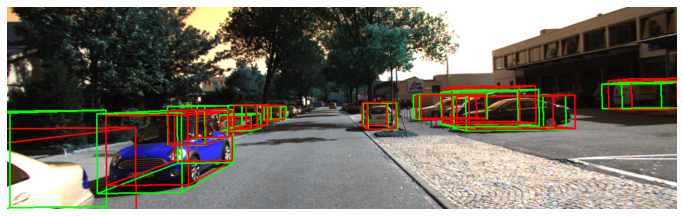

In [ ]:
index = 3107
img = cv2.imread("drive/images/003107.png")
calib_path = "drive/calib/003107.txt"
test_calib = read_calib_file(calib_path)
count =0
idx = 0
for j in test_index:
  for i in range(int(labels_in_each_image[int(j)])):
    if j == index:
      test_point = test_clouds[count]
      test_point = test_point.reshape(1,400,3)
      test_class = test_classes[count]
      test_label = test_labels[count]   
      test_inter = test_intermediate[count].reshape(1,2048)
      box, classes = model.predict([test_point,test_inter])
      box = box.reshape(8,3)
      img = draw_3D_boundingbox(box, 'Pedestrian', test_calib, count, img, np.max(classes))
    count = count + 1

plt.subplots(1,1, figsize = (12,4))
plt.axis('off')
plt.imshow(img)
#iou = "{0:.2f}".format(IoU(box_corners, box_truth))
#cl_prob = "{0:.2f}".format(cl_prob)
#making figure

#plt.title("Image with 3D bounding box; IOU = " + str(iou) +"  Class Probability = " + str(cl_prob) )
#fig.savefig('BB_'+str(index)+'.eps', format='eps', dpi=1200)

>> Average IoU





In [ ]:
indices = np.load('drive/Colab Notebooks/index.npy')
labels_in_each_image = np.load('drive/multi/labels_in_each_image.npy')
test_index = indices[6748:]
test_iou = []
count = 0
for j in test_index:
  for i in range(int(labels_in_each_image[int(j)])):
    test_point = test_clouds[count]
    test_point = test_point.reshape(1,400,3)
    test_class = test_classes[count]
    test_label = test_labels[count]
    test_inter = test_intermediate[count].reshape(1,2048)
    box, classes = model.predict([test_point,test_inter])
    box = box.reshape(8,3)
    iou = IoU(box, test_label)
    test_iou.append(iou)
    count = count+1
  #  if iou<0.5:
  #    print(j)

avg_iou = sum(test_iou)/len(test_iou)
print(avg_iou)

0.42118333955860665


# Testing on Unlabelled Data

## Image Cropping

In [ ]:
# This Colab requires TF 2.5.
!pip install -U tensorflow>=2.5

import os
import pathlib

import matplotlib
import matplotlib.pyplot as plt

import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from six.moves.urllib.request import urlopen

import tensorflow as tf
import tensorflow_hub as hub

tf.get_logger().setLevel('ERROR')
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: the file path to the image

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  image = None
  if(path.startswith('http')):
    response = urlopen(path)
    image_data = response.read()
    image_data = BytesIO(image_data)
    image = Image.open(image_data)
  else:
    image_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(image_data))

  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (1, im_height, im_width, 3)).astype(np.uint8)


COCO17_HUMAN_POSE_KEYPOINTS = [(0, 1),
 (0, 2),
 (1, 3),
 (2, 4),
 (0, 5),
 (0, 6),
 (5, 7),
 (7, 9),
 (6, 8),
 (8, 10),
 (5, 6),
 (5, 11),
 (6, 12),
 (11, 12),
 (11, 13),
 (13, 15),
 (12, 14),
 (14, 16)]

In [ ]:
!git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 2713, done.
remote: Counting objects: 100% (2713/2713), done.
remote: Compressing objects: 100% (2252/2252), done.
remote: Total 2713 (delta 690), reused 1244 (delta 427), pack-reused 0
Receiving objects: 100% (2713/2713), 32.69 MiB | 31.40 MiB/s, done.
Resolving deltas: 100% (690/690), done.


In [ ]:
%%bash
sudo apt install -y protobuf-compiler
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Reading package lists...
Building dependency tree...
Reading state information...
protobuf-compiler is already the newest version (3.0.0-9.1ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 47 not upgraded.
Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-cp37-none-any.whl size=1654779 sha256=244d3ba3b2dbecebf97b96168aa368b0b75381492d2e8e115899772c3b616b64
  Stored in directory: /tmp/pip-ephem-wheel-cache-4cv3a435/wheels/94/49/4b/39b051683087a22ef7e80ec52152a27249d1a644ccf4e442ea
  Created wheel for avro-python3: filename=avro_python3-1.10.2-cp37-none-any.whl size=44011 sha256=5178208a0398d32c320757b1e4fe12fe7c7e817d71d48b2d1acffdd35253ae6d
  Stored in directory: /root/.cache/pip/wheels/ee/ee/18/c466221ca6900e3efce2f4ea9c329288808679aecdcb2838d3
  Created wheel for future: filename=future-0.18.2-cp37-none-any.whl size=491070 sha256=48deb80605e8d7a3d4d6b87755cf1bab541c6f8127452dc64d25fb4166a1c1fa
  Stored in directory: /root/



ERROR: multiprocess 0.70.12.2 has requirement dill>=0.3.4, but you'll have dill 0.3.1.1 which is incompatible.
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: apache-beam 2.30.0 has requirement avro-python3!=1.9.2,<1.10.0,>=1.8.1, but you'll have avro-python3 1.10.2 which is incompatible.


In [ ]:
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import ops as utils_ops

%matplotlib inline
PATH_TO_LABELS = './models/research/object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

#model_display_name = 'Faster R-CNN Inception ResNet V2 1024x1024'
model_handle = 'https://tfhub.dev/tensorflow/faster_rcnn/inception_resnet_v2_1024x1024/1'

print('loading model...')
hub_model = hub.load(model_handle)
print('model loaded!')
image_path = 'drive/Test Images/000004.png' 
image_np = load_image_into_numpy_array(image_path)

plt.figure(figsize=(24,32))
plt.imshow(image_np[0])
plt.show()

# running inference
results = hub_model(image_np)

# different object detection models have additional results
# all of them are explained in the documentation
result = {key:value.numpy() for key,value in results.items()}
print(result.keys())

label_id_offset = 0
image_np_with_detections = image_np.copy()

# Use keypoints if available in detections
keypoints, keypoint_scores = None, None
if 'detection_keypoints' in result:
  keypoints = result['detection_keypoints'][0]
  keypoint_scores = result['detection_keypoint_scores'][0]
boxes = np.squeeze(result['detection_boxes'])
print(boxes[0])
viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections[0],
      result['detection_boxes'][0],
      (result['detection_classes'][0] + label_id_offset).astype(int),
      result['detection_scores'][0],
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=22,
      min_score_thresh=.81,
      agnostic_mode=False,
      keypoints=keypoints,
      keypoint_scores=keypoint_scores,
      keypoint_edges=COCO17_HUMAN_POSE_KEYPOINTS)

plt.figure(figsize=(24,32))
plt.imshow(image_np_with_detections[0])
plt.show()
#result['detection_boxes'][0][0][0]*image_np.shape[1]

In [ ]:
boxes = np.squeeze(result['detection_boxes'])
print(boxes[0])
boxes[:,0] = boxes[:,0] * image_np.shape[1]
boxes[:,1] = boxes[:,1] * image_np.shape[2]
boxes[:,2] = boxes[:,2] * image_np.shape[1]
boxes[:,3] = boxes[:,3] * image_np.shape[2]
#print(result['detection_boxes'])

[2.4342302e+07 4.2228534e+08 2.7651950e+07 5.1678067e+08]


In [ ]:
print(boxes[99])

[178.316  635.9922 190.3243 643.0613]


In [ ]:
np.save('drive/multi/2D_test_boxes_3.npy',boxes)

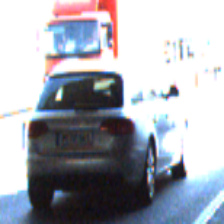

(100, 224, 224, 3)
(100, 4)


In [ ]:
#Shifting the minimum value of x and y coordinates by 10% less and shifting the maximum value of x and y coordinates by 10% more as specified by PointFusion paper
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
boxes = np.load('drive/multi/2D_test_boxes_3.npy')
roi_images = None
img = cv2.imread('drive/Test Images/000003.png')
for i in range(boxes.shape[0]):
  ymin = boxes[i][0]
  xmin = boxes[i][1]
  ymax = boxes[i][2]
  xmax = boxes[i][3]
  if ymin-0.1*(ymax-ymin)>=0 and xmin-0.1*(xmax-xmin)>=0:
    roi_imgOne = img[int(ymin-0.1*(ymax-ymin)):int(ymax+0.1*(ymax-ymin)),int(xmin-0.1*(xmax-xmin)):int(xmax+0.1*(xmax-xmin))]
          
  if ymin-0.1*(ymax-ymin)>=0 and xmin-0.1*(xmax-xmin)<0:
    roi_imgOne = img[int(ymin-0.1*(ymax-ymin)):int(ymax+0.1*(ymax-ymin)),0:abs(int(xmax+0.1*(xmax-xmin)))] 
          
  if ymin-0.1*(ymax-ymin)<0 and xmin-0.1*(xmax-xmin)>=0:
    roi_imgOne = img[0:abs(int(ymax+0.1*(ymax-ymin))),int(xmin-0.1*(xmax-xmin)):int(xmax+0.1*(xmax-xmin))]
          
  if ymin-0.1*(ymax-ymin)<0 and xmin-0.1*(xmax-xmin)<0:
    roi_imgOne = img[0:abs(int(ymax+0.1*(ymax-ymin))),0:abs(int(xmax+0.1*(xmax-xmin)))]

  roi_imgTwo = cv2.resize(roi_imgOne,(224,224))
  roi_img = np.expand_dims(roi_imgTwo, axis=0)
  if roi_images is None:
    roi_images = roi_img
  else:
    roi_images = np.concatenate((roi_images,roi_img), axis = 0)
cv2_imshow(roi_images[2])
print(roi_images.shape)
print(boxes.shape)


In [ ]:
from keras.applications import resnet50
resnet_model = resnet50.ResNet50(weights='imagenet')
roi_pre = resnet50.preprocess_input(roi_images)

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

#tf.compat.v1.get_default_graph()
#extract final layer called avg_pool with size 1 by 2048
layer_name = 'avg_pool'
layer = resnet_model.get_layer(layer_name)
#layer = resnet_model.layers[layer_num]

intermediate_layer_model = Model(inputs=resnet_model.input,
                                 outputs=layer.output)
intermediate_layer_model.summary()
resnet_output = intermediate_layer_model.predict(roi_pre)
print("Shape of Processed Images: ", roi_pre.shape)
print("Layer used: ", layer.name)
print("Shape of layer output:", resnet_output.shape)

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

## PointCloud Cropping

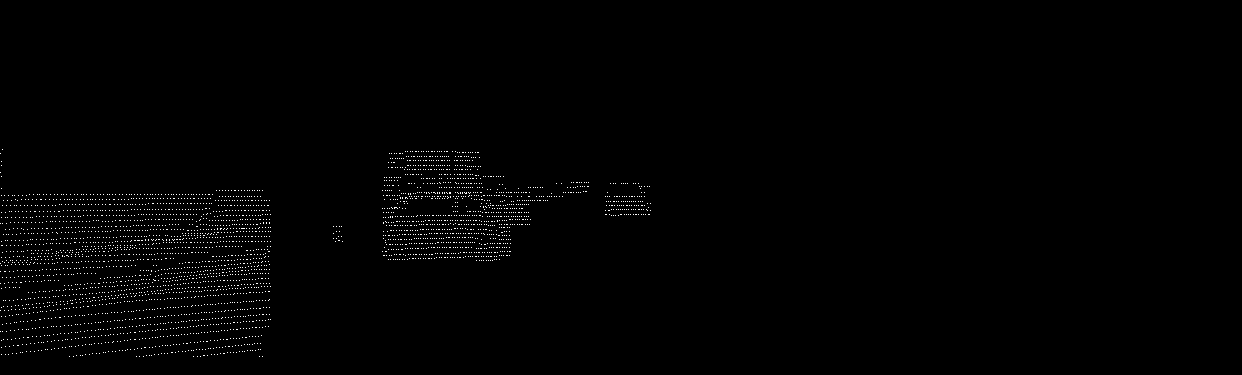

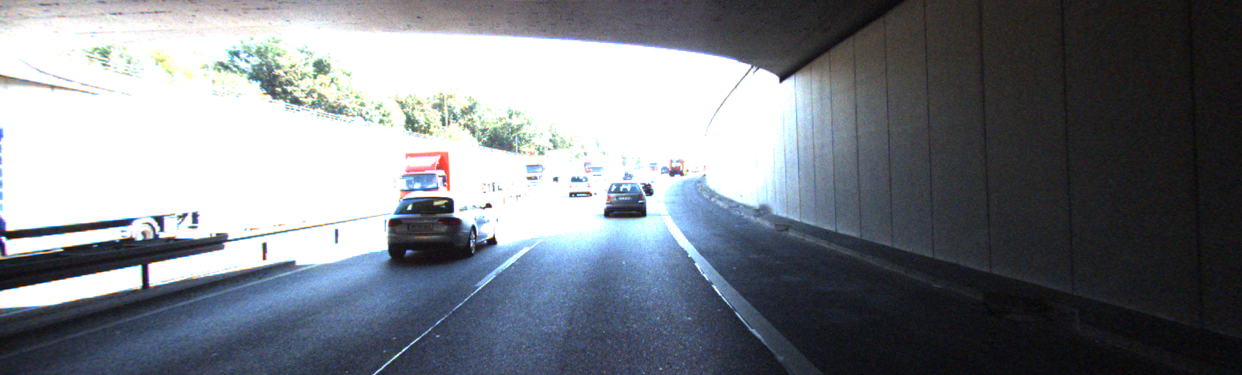

In [ ]:
def load_pc_from_bin(bin_path):
    selected_points =[]
    obj = np.fromfile(bin_path, dtype = np.float32).reshape(-1,4)
    pc = filter_camera_angle(obj)
    selected_points.append(pc[:,:3])
    selected_points = np.array(selected_points).reshape(-1,3)# return N*3 array
    return selected_points

def filter_camera_angle(places):
    bool_in = np.logical_and((places[:, 1] < places[:, 0] - 0.27), (-places[:, 1] < places[:, 0] - 0.27))
    return places[bool_in]

def velocorners_to_imagecorners(point,calib_data):
    point.append(1)
    #print(point)
    point = np.array(point).reshape((4,1))
    
    R0_rect = calib_data["R0_rect"].reshape(3, 3)
    Tr_velo_to_cam = calib_data["Tr_velo_to_cam"].reshape(3, 4)
    P2 = calib_data["P2"].reshape(3, 4)
    
    R = np.zeros((4,4))
    R[:3,:3] = R0_rect
    R[3,3] = 1
    
    T = np.zeros((4,4))
    T[:3,:4] = Tr_velo_to_cam
    T[3,3] = 1
    
    point_image = np.dot(P2,np.dot(R,np.dot(T,point)))
    return list(np.squeeze(point_image.reshape(1,3)))


def read_calib_file(calib_path):
    """Read a calibration file."""
    data = {}
    with open(calib_path, 'r') as f:
        for line in f.readlines():
            if not line or line == "\n":
                continue
            key, value = line.split(':', 1)
            try:
                data[key] = np.array([float(x) for x in value.split()])
            except ValueError:
                pass
    return data
im = cv2.imread('drive/Test Images/000003.png')
imT = np.zeros((im.shape[0],im.shape[1]),dtype = 'uint8')
#imT = np.zeros((5000,5000))
images_corners_2d = boxes

bin_path = 'drive/Test Clouds/000003.bin'
pc = load_pc_from_bin(bin_path) 
pc_roi =  np.zeros((len(images_corners_2d),400,3))
calib_path = 'drive/Test calib/000003.txt'
calib_data = read_calib_file(calib_path)
clouds = None
for j in range(len(images_corners_2d)):
    ymin = images_corners_2d[j][0]
    xmin = images_corners_2d[j][1]
    ymax = images_corners_2d[j][2]
    xmax = images_corners_2d[j][3]
    flag=0
    cloud = None
    for i in range(pc.shape[0]):
      pc_point = list(pc[i])
      pc_on_img = velocorners_to_imagecorners(pc_point,calib_data)
      pc_on_img = pc_on_img/pc_on_img[2]       
      if (pc_on_img[0] > float(xmin)) and (pc_on_img[1] >= float(ymin)) and (pc_on_img[0] <= float(xmax)) and  (pc_on_img[1] <= float(ymax)):
          imT[int(pc_on_img[1]),int(pc_on_img[0])] +=255
          if flag==0:
            cloud = pc[i,:]
            cloud = np.expand_dims(cloud,axis=0)
            flag=1
          else:
            temp = pc[i,:]
            temp = np.expand_dims(temp,axis=0)                         
            cloud = np.append(cloud,temp,axis=0)
            clouds=cloud

    if clouds.shape[0]<400:
      pc_roi[j,:clouds.shape[0]] = clouds
      pc_roi[j,clouds.shape[0]:] = clouds[0] 
    else:
      p = np.random.choice(clouds.shape[0],400,replace=False)
      pc_roi[j] = clouds[p]

cv2_imshow(imT)
cv2_imshow(im)

## Required Functions

In [ ]:
def velocorners_to_imagecorners(point,calib_data):
    '''converts velo points to image points
    Based on the readme file for 3D object detection, x = P2 * R0_rect * Tr_velo_to_cam * y
    R0_rect contains a 3x3 matrix which you need to extend to a 4x4 matrix by adding a 1 as the bottom-right element 
    and 0's elsewhere.
    Tr_xxx is a 3x4 matrix (R|t), which you need to extend to a 4x4 matrix in the same way
    Remember, that calib data has to extracted for the relevant file instance
    
    Input: 
    point: 1 point in the velodyne coordinate, a list
    calib_data: calib file for that example
    
    Output:
    point in the 2D image coordinate as a 3 member list
    
    Scheme of i'''
    #appending the point with 1 for homogenization and making a numpy array
    point.append(1)
    point = np.array(point).reshape((4,1))
    
    R0_rect = calib_data["R0_rect"].reshape(3, 3)
    Tr_velo_to_cam = calib_data["Tr_velo_to_cam"].reshape(3, 4)
    P2 = calib_data["P2"].reshape(3, 4)
    
    R = np.zeros((4,4))
    R[:3,:3] = R0_rect
    R[3,3] = 1
    
    T = np.zeros((4,4))
    T[:3,:4] = Tr_velo_to_cam
    T[3,3] = 1
    
    point_image = np.dot(P2,np.dot(R,np.dot(T,point)))
    return list(np.squeeze(point_image.reshape(1,3)))
    
   
def draw_3D_boundingbox(box_Corners, cl, calib_data, index, image, cl_prob):
    """Draws 3D bounding boxes
    Input:
    box_corners: a list of 8 box corners, each being a list with (x,y,z)
    cl: classification of object for that example, a string of Car, Van, or a Pedestrian
    calib_data: calib_data for that example
    index: example_index
    
    Output: plots figure along with saving it as BB_index.eps in the current directory
    """
    
    #order for finding points to line
    line_order = ([0,1],[1,5],[5,4],[4,0],[5,7],[4,6],[7,6],[6,2],[2,3],[3,7],[3,1],[0,2])

    #color scheme for different objects
    type_c = { 'Car': (0, 255, 0), 'Van': (0, 255, 0), 'Pedestrian': (0,255,0) }

    #have to feed 
    tracklet2d = []

    xmin=np.amin(box_Corners[:,0])
    xmax=np.amax(box_Corners[:,0])
    ymin=np.amin(box_Corners[:,1])
    ymax=np.amax(box_Corners[:,1])
    zmin=np.amin(box_Corners[:,2])
    zmax=np.amax(box_Corners[:,2])
    box_corners=[(xmin,ymin,zmin),(xmin,ymin,zmax),(xmin,ymax,zmin),(xmin,ymax,zmax),
             (xmax,ymin,zmin),(xmax,ymin,zmax),(xmax,ymax,zmin),(xmax,ymax,zmax)]
    for i in box_corners:
        point_image = velocorners_to_imagecorners(list(i), calib_data)
        point_image = point_image/point_image[2]
        tracklet2d.append(point_image)
    tracklet2d = np.array(tracklet2d)
    
    for k in line_order:    
        cv2.line(image, (int(tracklet2d[k[0]][0]), int(tracklet2d[k[0]][1])), (int(tracklet2d[k[1]][0]), int(tracklet2d[k[1]][1])), (0,255,0), 2)
    return image


def read_calib_file(calib_path):
    """Read a calibration file."""
    data = {}
    with open(calib_path, 'r') as f:
        for line in f.readlines():
            if not line or line == "\n":
                continue
            key, value = line.split(':', 1)
            try:
                data[key] = np.array([float(x) for x in value.split()])
            except ValueError:
                pass
    return data


## Model Definition for Feedforward Pass

In [ ]:
def mat_mul(A, B):
    return tf.matmul(A, B)


# number of points in each sample
num_points = 400

# number of categories
k = 7

# define optimizer
adam = optimizers.Adam(lr=0.001, decay=0.7)

# ------------------------------------ Pointnet Architecture
# input_Transformation_net
input_points = Input(shape=(num_points, 3))
x = Convolution1D(64, 1, activation='relu',
                  input_shape=(num_points, 3))(input_points)
#x = BatchNormalization()(x)
x = Convolution1D(128, 1, activation='relu')(x)
#x = BatchNormalization()(x)
x = Convolution1D(1024, 1, activation='relu')(x)
#x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=num_points)(x)
x = Dense(512, activation='relu')(x)
#x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
#x = BatchNormalization()(x)
x = Dense(9, weights=[np.zeros([256, 9]), np.array([1, 0, 0, 0, 1, 0, 0, 0, 1]).astype(np.float32)])(x)
input_T = Reshape((3, 3))(x)

# forward net
g = Lambda(mat_mul, arguments={'B': input_T})(input_points)
g = Convolution1D(64, 1, input_shape=(num_points, 3), activation='relu')(g)
#g = BatchNormalization()(g)
g = Convolution1D(64, 1, input_shape=(num_points, 3), activation='relu')(g)
#g = BatchNormalization()(g)

# feature transform net
f = Convolution1D(64, 1, activation='relu')(g)
#f = BatchNormalization()(f)
f = Convolution1D(128, 1, activation='relu')(f)
#f = BatchNormalization()(f)
f = Convolution1D(1024, 1, activation='relu')(f)
#f = BatchNormalization()(f)
f = MaxPooling1D(pool_size=num_points)(f)
f = Dense(512, activation='relu')(f)
#f = BatchNormalization()(f)
f = Dense(256, activation='relu')(f)
#f = BatchNormalization()(f)
f = Dense(64 * 64, weights=[np.zeros([256, 64 * 64]), np.eye(64).flatten().astype(np.float32)])(f)
feature_T = Reshape((64, 64))(f)

# forward net
g = Lambda(mat_mul, arguments={'B': feature_T})(g)
g = Convolution1D(64, 1, activation='relu')(g)
#g = BatchNormalization()(g)
g = Convolution1D(128, 1, activation='relu')(g)
#g = BatchNormalization()(g)
g = Convolution1D(1024, 1, activation='relu')(g)
#g = BatchNormalization()(g)

# global_feature
global_feature = MaxPooling1D(pool_size=num_points)(g)
global_feature = Flatten()(global_feature)
#f =Flatten()(global_feature)
# point_net_cls
#c = Dense(512, activation='relu')(global_feature)
#c = BatchNormalization()(c)
#c = Dropout(rate=0.7)(c)
#c = Dense(256, activation='relu')(c)
#c = BatchNormalization()(c)
#c = Dropout(rate=0.7)(c)
#c = Dense(k, activation='softmax')(c)
#prediction = Flatten()(c)
# --------------------------------------------------end of pointnet

#Fusion
resnet_activation = Input(shape=(resnet_output.shape[1],), name='intermediate_output')
f = Concatenate()([global_feature, resnet_activation])

#Definition of MLP Layer
f = Dense(512, activation='relu')(f)
f = Dense(128, activation='relu')(f)
f = Dense(128, activation='relu')(f)
box = Dense(24)(f)
classes = Dense(7,activation='sigmoid')(f)


# print the model summary
model = Model(inputs=[input_points, resnet_activation], outputs=[box, classes])
#model = Model(inputs=[input_points,], outputs=[boxes,classes])

#model.load_weights('my_model_weights_450.h5')
model.load_weights('drive/Colab Notebooks/weights-multiple-100-2.0.h5')
#model.load_weights('drive/Colab Notebooks/weights_multiple_200.h5')
print(model.summary())

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 400, 3)       0                                            
__________________________________________________________________________________________________
lambda_7 (Lambda)               (None, 400, 3)       0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1d_37 (Conv1D)              (None, 400, 64)      256         lambda_7[0][0]                   
__________________________________________________________________________________________________
conv1d_38 (Conv1D)              (None, 400, 64)      4160        conv1d_37[0][0]                  
____________________________________________________________________________________________

## Making Predictions

[[0.73004556 0.09079638 0.00119618 0.00333952 0.00218661 0.0462838
  0.13862869]]


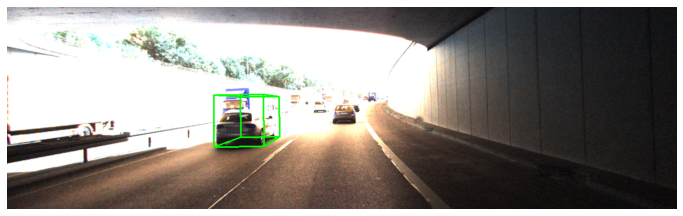

In [ ]:
img = cv2.imread("drive/Test Images/000003.png")
calib_path = "drive/Test calib/000003.txt"
test_calib = read_calib_file(calib_path)
count =0
for i in range(int(pc_roi.shape[0])):
  if count==2:
    test_point = pc_roi[count]
    test_point = test_point.reshape(1,400,3)
    test_inter = resnet_output[count].reshape(1,2048)
    box, classes = model.predict([test_point,test_inter])
    print(classes)
    box = box.reshape(8,3)
    img = draw_3D_boundingbox(box, 'Pedestrian', test_calib, count, img, np.max(classes))
  count = count + 1

plt.subplots(1,1, figsize = (12,4))
plt.axis('off')
plt.imshow(img)
#iou = "{0:.2f}".format(IoU(box_corners, box_truth))
#cl_prob = "{0:.2f}".format(cl_prob)
#making figure

#plt.title("Image with 3D bounding box; IOU = " + str(iou) +"  Class Probability = " + str(cl_prob) )
#fig.savefig('BB_'+str(index)+'.eps', format='eps', dpi=1200)

In [ ]:
a= np.load('drive/multi/pointclouds_multiple.npy')
!pip3 install open3d
 #Pass xyz to Open3D.o3d.geometry.PointCloud and visualize
import open3d as o3d
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(np.squeeze(a[6]))#pc_roi[0]))
o3d.io.write_point_cloud("drive/roi_cropped_pc.pcd", pcd)

True